In [1]:
from contour_visualization.Gaussian import Gaussian
from contour_visualization import picture_plot

from gmm_dimension_reduction.slicing import slice_gmm
from gmm_dimension_reduction import GaussianMixtureModel

No module named 'mb_modelbase'


In [2]:
import sys
print(sys.version)

3.8.5 (default, Mar 19 2021, 22:32:04) 
[GCC 7.5.0]


In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import datasets
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def normalize_df(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=df.columns)

In [6]:
def _read(file):
    df = pd.read_csv(file)
    df = pd.DataFrame(df, columns=['trans', 'cyl', 'T', 'class', 'year', 'cty', 'hwy', 'displ'])
    df = df.rename(columns={'cty': 'mpg_city', 'hwy': 'mpg_highway', 'trans': 'transmission',
                            'T': 'turbo', 'cyl': 'cylinder', 'class': 'car_size', 'displ': 'displacement'})
    return df

def cg_4cat3cont(file, do_not_change=[]):
    df = _read(file)
    df = pd.DataFrame(df, columns=['transmission', 'cylinder', 'turbo', 'car_size', 'year', 'mpg_city', 'mpg_highway', 'displacement'])

    df.car_size.replace(to_replace={'pickup': 'large', 'suv': 'midsize', 'station wagon': 'midsize',
                                     'compact': 'small', 'passenger van': 'large', 'cargo van': 'large', 'two seater': 'small', 'large car': 'large', 'midsize car': 'midsize', 'compact car': 'small'}, inplace=True)

    if 'cylinder' not in do_not_change:
        df.cylinder.replace(to_replace={2: 'few', 3: 'few', 4: 'few', 5: 'medium', 6: 'medium',
                                        7: 'medium', 8: 'medium', 10: 'many', 12: 'many', 16: 'many'}, inplace=True)

    df.replace(to_replace={'transmission': {
        '.*auto.*': 'auto'}}, inplace=True, regex=True)
    
    df.replace(to_replace={'transmission': {
        'lock-up.*': 'lock-up'}}, inplace=True, regex=True)
    
    df.replace(to_replace={'transmission': {
        'manual.*': 'manual'}}, inplace=True, regex=True)
    
    df = df.drop(df[df.transmission == 'semi-auto'].index)
    df = df.drop(df[df.transmission == 'creeper(C5)'].index)
    df = df.drop(df[df.car_size == 'spv'].index)
    df = df.dropna(axis=0)
    df.reset_index(drop=True, inplace=True)

    for col in ['transmission', 'cylinder', 'turbo', 'car_size']:
        df[col] = df[col].astype('str')

    del df['turbo']

    return df

## Weather australia (2018 - 2020)

In [151]:
df = pd.read_csv("predicting_rain/own_3_data.csv")
df

,Station,Day(Local_Date),WDir(Deg),WSpd(m/s),GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),...,Tgmin(C),ET05(C),ET10(C),ET20(C),ET30(C),ET100(C),Pmsl(hPa),Pstn(hPa),Sun(Hrs),Rad(MJ/m2)
0,1287,20100101:0000,186,3.6,212,8.2,266,0.0,18.1,14.1,...,-,-,-,-,-,-,1022.8,1018.0,-,32.58
1,1400,20100101:0000,240,5.9,-,-,396,0.0,16.4,13.0,...,-,-,-,-,-,-,1022.6,1010.9,-,-
2,1520,20100101:0000,-,-,-,-,-,0.0,17.5,13.5,...,-,-,-,-,-,-,1021.4,1021.0,-,-
3,1529,20100101:0000,-,-,-,-,318,0.0,20.0,15.0,...,18.0,-,-,-,-,-,-,-,8.0,-
4,1547,20100101:0000,245,1.2,307,9.8,213,0.0,16.2,13.5,...,-,-,-,-,-,-,1021.6,1019.5,-,30.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6310,26117,20101227:0000,124,0.8,14,9.3,317,0.8,17.2,14.4,...,3.7,-,18.0,18.3,-,18.2,-,-,5.4,22.80
6311,26492,20101227:0000,163,0.6,44,7.7,249,0.0,20.6,16.8,...,-,-,-,-,-,-,-,-,-,16.16
6312,37852,20101227:0000,24,2.4,13,10.8,429,0.4,20.8,18.0,...,10.1,-,20.3,20.8,-,-,-,-,7.0,15.02
6313,38619,20101227:0000,111,2.2,354,10.3,578,0.0,-,-,...,-,-,-,-,-,-,1018.0,-,-,-


In [152]:
0.598930, 0.543379, 0.771588, 0.065455, 0.950000, 0.500000

(0.59893, 0.543379, 0.771588, 0.065455, 0.95, 0.5)

In [153]:
df.columns

Index(['Station', 'Day(Local_Date)', 'WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)',
       'GustSpd(m/s)', 'WindRun(Km)', 'Rain(mm)', 'Tdry(C)', 'TWet(C)',
       'RH(%)', 'Tmax(C)', 'Tmin(C)', 'Tgmin(C)', 'ET05(C)', 'ET10(C)',
       'ET20(C)', 'ET30(C)', 'ET100(C)', 'Pmsl(hPa)', 'Pstn(hPa)', 'Sun(Hrs)',
       'Rad(MJ/m2)'],
      dtype='object')

In [154]:
col_del = ["Day(Local_Date)", "Station", "Pstn(hPa)", "ET05(C)", "ET10(C)", "ET20(C)", "ET30(C)", "ET100(C)", "Tgmin(C)", "Pmsl(hPa)", "Rad(MJ/m2)"]

In [155]:
for i in col_del:
    del df[i]

In [156]:
df

,WDir(Deg),WSpd(m/s),GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),RH(%),Tmax(C),Tmin(C),Sun(Hrs)
0,186,3.6,212,8.2,266,0.0,18.1,14.1,62.0,25.0,12.9,-
1,240,5.9,-,-,396,0.0,16.4,13.0,65.9,23.6,12.6,-
2,-,-,-,-,-,0.0,17.5,13.5,61.5,25.9,13.0,-
3,-,-,-,-,318,0.0,20.0,15.0,55.8,25.0,13.0,8.0
4,245,1.2,307,9.8,213,0.0,16.2,13.5,72.4,25.1,10.1,-
...,...,...,...,...,...,...,...,...,...,...,...,...
6310,124,0.8,14,9.3,317,0.8,17.2,14.4,72.0,26.1,8.1,5.4
6311,163,0.6,44,7.7,249,0.0,20.6,16.8,66.0,23.8,10.8,-
6312,24,2.4,13,10.8,429,0.4,20.8,18.0,75.0,24.0,13.8,7.0
6313,111,2.2,354,10.3,578,0.0,-,-,-,27.3,8.3,-


In [157]:
columns= {
    "WDir(Deg)": "Wind Direction",
    "WSpd(m/s)": "Wind Speed",
    "Tmax(C)": "Max Temp",
    "Tmin(C)": "Min Temp",
    "RH(%)": "Rel. Humidity",
    "Sun(Hrs)": "Sun Hours",
}

In [158]:
for i in df.columns:
    df = df[df[i] != "-"]

In [159]:
df = df.astype("float")

In [160]:
df.dtypes

WDir(Deg)       float64
WSpd(m/s)       float64
GustDir(Deg)    float64
GustSpd(m/s)    float64
WindRun(Km)     float64
Rain(mm)        float64
Tdry(C)         float64
TWet(C)         float64
RH(%)           float64
Tmax(C)         float64
Tmin(C)         float64
Sun(Hrs)        float64
dtype: object

In [161]:
df = df.rename(columns, axis='columns')

In [162]:
df

,Wind Direction,Wind Speed,GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),Rel. Humidity,Max Temp,Min Temp,Sun Hours
10,217.0,6.8,252.0,12.4,526.0,0.0,16.7,13.0,63.0,20.1,14.2,6.4
13,226.0,4.9,235.0,12.4,274.0,0.0,17.0,13.1,62.0,22.4,11.9,12.3
15,234.0,2.3,258.0,9.8,192.0,0.0,16.8,13.1,63.0,21.9,13.2,9.5
27,271.0,3.9,216.0,10.8,340.0,0.0,17.8,14.4,67.0,22.6,14.5,11.7
30,298.0,2.0,241.0,10.3,247.0,0.0,17.4,14.5,71.0,22.4,8.8,13.2
...,...,...,...,...,...,...,...,...,...,...,...,...
6291,24.0,0.8,270.0,8.8,184.0,0.0,15.2,13.9,86.0,21.4,8.6,4.0
6293,256.0,1.5,248.0,8.2,138.0,0.2,17.7,14.6,70.0,22.6,14.2,8.3
6307,24.0,3.0,45.0,16.0,581.0,1.4,21.6,18.4,72.0,23.6,13.9,5.8
6310,124.0,0.8,14.0,9.3,317.0,0.8,17.2,14.4,72.0,26.1,8.1,5.4


In [163]:
df_aust

,Max Temp,Min Temp,Wind Direction,Wind Speed,Sun Hours,Rel. Humidity,Rain Amount,Outcome
0,21.8,11.9,278.0,4.0,13.3,69.0,0.0,0
1,23.9,15.2,196.0,10.8,13.3,69.0,0.0,0
2,23.3,14.1,269.0,3.6,7.6,79.0,0.0,0
3,27.0,15.8,209.0,7.9,13.3,76.0,0.0,0
4,24.4,14.2,299.0,4.0,8.8,71.0,0.0,0
...,...,...,...,...,...,...,...,...
1090,23.3,16.7,204.0,18.0,11.8,60.0,0.2,1
1091,23.0,13.2,182.0,14.0,11.0,38.0,0.0,0
1092,20.4,15.0,198.0,19.8,13.4,62.0,0.0,0
1093,23.2,14.3,246.0,5.4,13.3,74.0,0.0,0


In [ ]:
"Wind Direction", , "Rel. Humidity", "Sun Hours"

In [164]:
columns_merge = ["Max Temp", "Min Temp", "Sun Hours"]

In [165]:
df_merge = pd.merge(df, df_aust, on=columns_merge, how='inner')
df_merge

,Wind Direction_x,Wind Speed_x,GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),Rel. Humidity_x,Max Temp,Min Temp,Sun Hours,Wind Direction_y,Wind Speed_y,Rel. Humidity_y,Rain Amount,Outcome


In [88]:
df1

,Wind Direction,Wind Speed,GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),Rel. Humidity,Max Temp,Min Temp,Tgmin(C),ET20(C),Pmsl(hPa),Sun Hours,Rad(MJ/m2),Rain Amount,Outcome
0,5.0,1.0,257.0,6.2,140.0,0.0,20.5,16.7,66.0,25.7,15.6,13.8,19.6,1010.4,7.5,20.30,NaN,NaN
1,338.0,0.3,338.0,7.7,156.0,0.0,19.2,17.1,80.0,28.8,15.6,14.0,20.4,1012.3,4.5,20.10,NaN,NaN
2,61.0,1.3,335.0,7.2,156.0,0.0,20.8,17.4,70.0,29.2,16.3,15.0,21.4,1014.2,10.4,28.28,NaN,NaN
3,354.0,0.7,150.0,10.8,142.0,11.6,18.2,15.7,76.0,26.3,13.4,11.4,21.4,1010.8,4.2,16.20,NaN,NaN
4,196.0,3.2,195.0,7.2,193.0,2.6,16.7,15.7,90.0,20.5,16.1,15.8,20.2,995.3,0.1,8.34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,119.0,2.0,129.0,8.8,202.0,0.0,10.3,7.9,70.0,18.3,4.7,3.4,15.0,1019.7,10.4,22.05,NaN,NaN
1092,324.0,0.9,193.0,8.2,170.0,0.0,9.7,7.0,65.0,21.7,3.6,1.0,14.6,1021.1,13.9,32.91,NaN,NaN
1093,145.0,1.1,175.0,8.8,182.0,0.0,14.2,11.6,71.0,22.4,7.1,4.3,17.1,1019.0,12.2,30.73,NaN,NaN
1094,333.0,1.1,226.0,6.7,119.0,0.0,13.3,11.4,78.0,25.8,7.6,5.4,17.7,1020.8,13.3,29.00,NaN,NaN


In [89]:
df1['Duplicated'] = df1.duplicated(keep=False) # keep=False marks the duplicated row with a True
df_final = df1[~df1['Duplicated']] # selects only rows which are not duplicated.
del df_final['Duplicated'] # delete the indicator column

In [90]:
df_final

,Wind Direction,Wind Speed,GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),Rel. Humidity,Max Temp,Min Temp,Tgmin(C),ET20(C),Pmsl(hPa),Sun Hours,Rad(MJ/m2),Rain Amount,Outcome
0,5.0,1.0,257.0,6.2,140.0,0.0,20.5,16.7,66.0,25.7,15.6,13.8,19.6,1010.4,7.5,20.30,NaN,NaN
1,338.0,0.3,338.0,7.7,156.0,0.0,19.2,17.1,80.0,28.8,15.6,14.0,20.4,1012.3,4.5,20.10,NaN,NaN
2,61.0,1.3,335.0,7.2,156.0,0.0,20.8,17.4,70.0,29.2,16.3,15.0,21.4,1014.2,10.4,28.28,NaN,NaN
3,354.0,0.7,150.0,10.8,142.0,11.6,18.2,15.7,76.0,26.3,13.4,11.4,21.4,1010.8,4.2,16.20,NaN,NaN
4,196.0,3.2,195.0,7.2,193.0,2.6,16.7,15.7,90.0,20.5,16.1,15.8,20.2,995.3,0.1,8.34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,119.0,2.0,129.0,8.8,202.0,0.0,10.3,7.9,70.0,18.3,4.7,3.4,15.0,1019.7,10.4,22.05,NaN,NaN
1092,324.0,0.9,193.0,8.2,170.0,0.0,9.7,7.0,65.0,21.7,3.6,1.0,14.6,1021.1,13.9,32.91,NaN,NaN
1093,145.0,1.1,175.0,8.8,182.0,0.0,14.2,11.6,71.0,22.4,7.1,4.3,17.1,1019.0,12.2,30.73,NaN,NaN
1094,333.0,1.1,226.0,6.7,119.0,0.0,13.3,11.4,78.0,25.8,7.6,5.4,17.7,1020.8,13.3,29.00,NaN,NaN


In [106]:
df = normalize_df(df)

In [107]:
df.head()

,WDir(Deg),WSpd(m/s),GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(C),TWet(C),RH(%),Tmax(C),Tmin(C),Tgmin(C),ET20(C),Pmsl(hPa),Sun(Hrs),Rad(MJ/m2)
0,0.013889,0.188679,0.713092,0.265306,0.329238,0.000000,0.933579,0.870445,0.227273,0.762887,0.887029,0.851145,0.745283,0.433515,0.539568,0.604702
1,0.938889,0.056604,0.938719,0.341837,0.368550,0.000000,0.885609,0.886640,0.545455,0.869416,0.887029,0.858779,0.783019,0.468124,0.323741,0.598433
2,0.169444,0.245283,0.930362,0.316327,0.368550,0.000000,0.944649,0.898785,0.318182,0.883162,0.916318,0.896947,0.830189,0.502732,0.748201,0.854859
3,0.983333,0.132075,0.415042,0.500000,0.334152,0.130337,0.848708,0.829960,0.454545,0.783505,0.794979,0.759542,0.830189,0.440801,0.302158,0.476176
4,0.544444,0.603774,0.540390,0.316327,0.459459,0.029213,0.793358,0.829960,0.772727,0.584192,0.907950,0.927481,0.773585,0.158470,0.007194,0.229781


## Weather australia

In [169]:
df = pd.read_csv("predicting_rain/SPLOM_weather.csv")

In [170]:
df = df[df['Rel. Humidity'] != "-"]

In [171]:
df["Rel. Humidity"].unique()

array(['69', '79', '76', '71', '75', '66', '74', '67', '72', '63', '64',
       '65', '77', '60', '73', '62', '94', '80', '83', '87', '88', '53',
       '78', '82', '54', '68', '81', '86', '93', '70', '84', '95', '92',
       '98', '96', '90', '89', '59', '91', '97', '99', '85', '52', '61',
       '58', '56', '57', '43', '100', '50', '51', '38'], dtype=object)

In [172]:
df = df.astype({"Rel. Humidity": "float"})

In [173]:
df.dtypes

Max Temp          float64
Min Temp          float64
Wind Direction    float64
Wind Speed        float64
Sun Hours         float64
Rel. Humidity     float64
Rain Amount       float64
Outcome             int64
dtype: object

In [174]:
df = normalize_df(df)

In [175]:
df.head()

,Max Temp,Min Temp,Wind Direction,Wind Speed,Sun Hours,Rel. Humidity,Rain Amount,Outcome
0,0.598930,0.543379,0.771588,0.065455,0.950000,0.500000,0.0,0.0
1,0.711230,0.694064,0.543175,0.189091,0.950000,0.500000,0.0,0.0
2,0.679144,0.643836,0.746518,0.058182,0.542857,0.661290,0.0,0.0
3,0.877005,0.721461,0.579387,0.136364,0.950000,0.612903,0.0,0.0
4,0.737968,0.648402,0.830084,0.065455,0.628571,0.532258,0.0,0.0


## mpg

In [7]:
file = "mpg/mpg.csv"

In [15]:
df = cg_4cat3cont(file)

In [15]:
df = datasets.load_diabetes()

In [16]:
df = pd.DataFrame(df.data, columns=df.feature_names)

In [17]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## Weather germany

In [20]:
df = pd.read_csv("predicting_rain/recent_daily_weather_data_cleaned.csv", header=0)

In [23]:
df = df.dropna()

In [33]:
df[df.columns[4:]]

,mean_temperature,min_temperature_200cm,max_temperature_200cm,min_temperature_005cm,precipitation_amount,precipitation_type,mean_relative_humidity
510,9.9,5.3,13.2,2.0,1.3,4.0,86.67
511,8.9,4.5,14.5,1.8,0.0,0.0,72.83
512,8.4,1.3,15.0,-1.5,0.0,0.0,69.88
513,8.7,1.5,15.6,-0.9,0.0,0.0,68.46
514,9.8,2.0,16.6,-0.6,0.0,0.0,65.21
...,...,...,...,...,...,...,...
306824,8.8,5.8,11.0,3.1,0.7,4.0,93.67
306825,11.2,10.2,12.9,9.9,0.1,4.0,92.75
306826,8.2,5.6,10.9,3.0,0.0,4.0,85.17
306827,7.5,5.2,11.4,3.4,0.0,0.0,90.54


In [35]:
df = normalize_df(df[df.columns[4:]])

In [14]:
def slicing_plot_matrix(data, n_components=3, show_axes=False, **kwargs):

    # https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    _, numvars = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    gm = GaussianMixture(n_components=n_components, random_state=0).fit(data)

    # Plot the data.
    for i, j in tqdm(zip(*np.triu_indices_from(axes, k=1))):
        for x, y in [(i, j), (j, i)]:
            create_gmm_plot(axes[x, y], gm, data, [x, y], **kwargs)

    names = data.columns
    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i, i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                            ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    if show_axes:
        for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
            axes[j, i].xaxis.set_visible(True)
            axes[i, j].yaxis.set_visible(True)
    return fig

In [178]:
def __get_range(min_value, max_value, margin=0.1):
    return (max_value - min_value) * margin

def create_gmm_plot(ax, gm, df, features, size=200, show_points=False, *args, **kwargs):
    margin=0.3
    extends = [
        (min(df.min()) - __get_range(min(df.min()), max(df.max()), margin),
         max(df.max()) + __get_range(min(df.min()), max(df.max()), margin)),
        (min(df.min()) - __get_range(min(df.min()), max(df.max()), margin),
         max(df.max()) + __get_range(min(df.min()), max(df.max()), margin))
    ]
    #     extends = [
    #         (point.min() - __get_range(point.min(), point.max()),
    #          point.max() + __get_range(point.min(), point.max()))
    #         for point in [df[df.columns[features]].iloc[:, 0], df.iloc[:, 1]]
    #     ]
    weights_, means_, covariances_ = slice_gmm(features, gm.weights_, gm.means_, gm.covariances_)
    gmm = [Gaussian(weight=weights ,means=means , cov_matrix=covariances, size=size) for weights, means, covariances in zip(weights_, means_, covariances_)]
    picture_plot.plot_image(ax, gmm, xlim=extends[0], ylim=extends[1], *args, **kwargs)
    if show_points == True:
        ax.scatter(df[df.columns[features[1]]], df[df.columns[features[0]]], s=10**-2)
#     picture_plot.plot_image(ax, gmm, *args, **kwargs)
    

In [44]:
def double_scatterplot_matrix(data, lower_params, upper_params=None, n_components=3, show_axes=False, **kwargs):
    if lower_params and not upper_params:
        upper_params = lower_params
    # https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    _, numvars = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    gm = GaussianMixture(n_components=n_components, random_state=0).fit(data)

    # Plot the data.
    for i, j in tqdm(zip(*np.triu_indices_from(axes, k=1))):
        for x, y in [(i, j), (j, i)]:
            if x > y:
                create_gmm_plot(axes[x, y], gm, data, [x, y], **lower_params, **kwargs)
            else:
                create_gmm_plot(axes[x, y], gm, data, [x, y], **upper_params, **kwargs)

    names = data.columns
    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i, i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                            ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    if show_axes:
        for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
            axes[j, i].xaxis.set_visible(True)
            axes[i, j].yaxis.set_visible(True)
    return fig

5it [01:00, 11.92s/it]points in grid of z-coordinates too similar
6it [01:12, 11.93s/it]points in grid of z-coordinates too similar
9it [01:50, 12.41s/it]points in grid of z-coordinates too similar
10it [02:02, 12.21s/it]


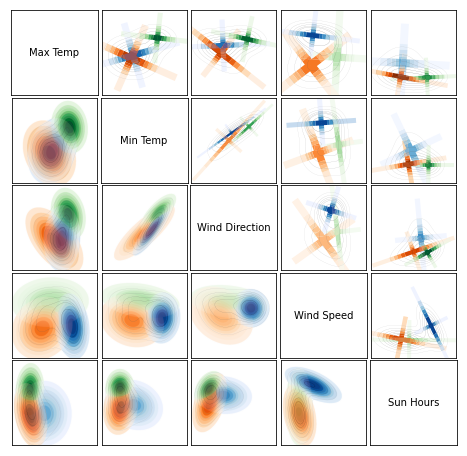

In [45]:
fig_cont_cross = double_scatterplot_matrix(df[df.columns[:5]], contour_params, cross_params, size=size, linewidth=.1)

In [46]:
fig_cont_cross.savefig("weatherdata_contour_cross.png", dpi=dpi, bbox_inches = 'tight', pad_inches = 0)

1it [00:03,  3.73s/it]


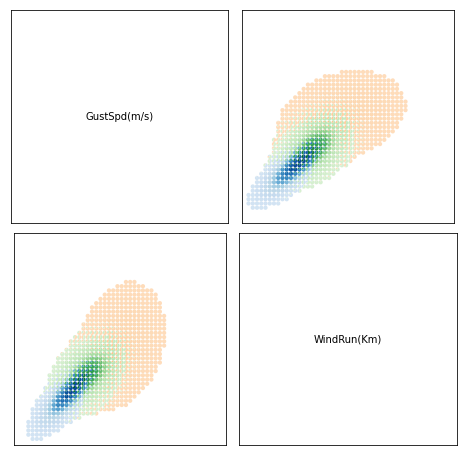

In [108]:
fig = slicing_plot_matrix(df[df.columns[3:5]], pie_charts=True, pie_num = 50, pie_angle=90, pie_chart_iso_level=80, pie_chart_contour_method="equal_density", pie_chart_modus="light")

In [112]:
columns = ["Tmax(C)", "Tmin(C)", "WDir(Deg)", "WSpd(m/s)", "Sun(Hrs)"]

In [25]:
dpi=500
size=500

In [26]:
contour_params = {
    "contours": True, 
    "contour_lines": True
}

In [27]:
cross_params = {
    "crosses": True, 
    "contour_lines": True
}

10it [00:08,  1.16it/s]


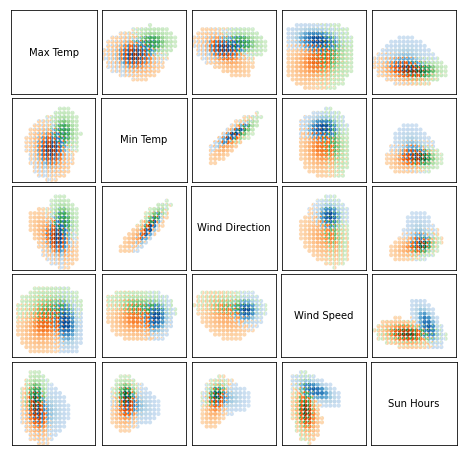

In [179]:
fig_pie = slicing_plot_matrix(df[df.columns[:5]], pie_charts=True, pie_num = 20, pie_angle=90, pie_chart_iso_level=40, pie_chart_contour_method="equal_density", pie_chart_modus="light")

In [180]:
fig_pie.savefig("weatherdata_pie.png", dpi=dpi, bbox_inches = 'tight', pad_inches = 0)

10it [03:50, 23.09s/it]


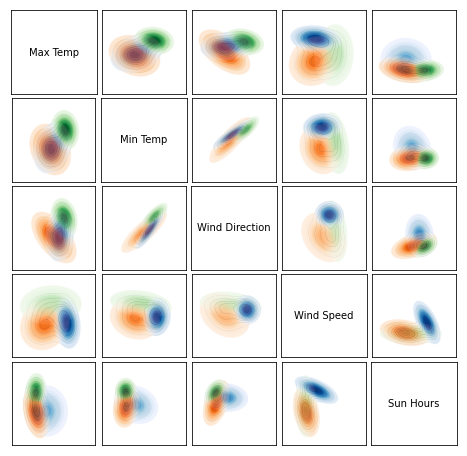

In [181]:
fig_contours = slicing_plot_matrix(df[df.columns[:5]], contours=True, contour_lines=True, size=size, linewidth=.1)

In [182]:
fig_contours.savefig("weatherdata_contour.png", dpi=dpi, bbox_inches = 'tight', pad_inches = 0)

5it [00:03,  1.35it/s]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
6it [00:04,  1.40it/s]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
9it [00:06,  1.36it/s]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
10it [00:07,  1.32it/s]


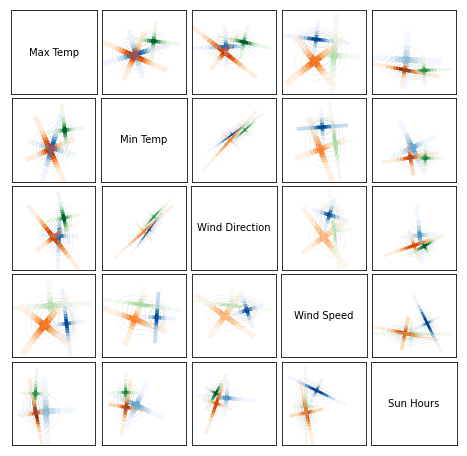

In [183]:
fig_crosses = slicing_plot_matrix(df[df.columns[:5]], crosses=True, contour_lines=True, linewidth=.1)

In [177]:
fig_crosses.savefig("weatherdata_crosses.png", dpi=dpi, bbox_inches = 'tight', pad_inches = 0)